In [1]:
%load_ext autoreload
%autoreload 2
%aimport scoring_utils
from scoring_utils import *
from sklearn.metrics import accuracy_score as acc, confusion_matrix as cm

### Load data; we use our lab-specific  procedure for loading data from plx/hdf/nex-files, and it can be replaced with analogous procedure that returns data in form of 2D numpy array (channels * times) 

In [2]:
eeg = open_plx(r"D:\cumchatka\sleep\26.11.2021.S1.5.hdf")

21.15211472 hours of data loaded: 3 channels, sampling rate = 1000


# Explore optimal frequency bands prior to vigilance states identification (optional)

### generate sets of frequency bands for NREM identification by providing rough delta and sigma frequency bands you want to search within (mininmum band width is 1 Hz and step is 0.5 Hz by default)

In [3]:
dbands, sbands = gen_d_s_bands(delta_freqs=(0, 6), sigma_freqs=(9.5, 16))

### calculate series of FFT amplitudes for all the bands obtained using the cortical channel

In [5]:
series = extract_fft_amps(eeg[0], dbands + sbands)

### calculate and visualize 3 cluster metrics for each series based on the 2-component GMM fitted on it

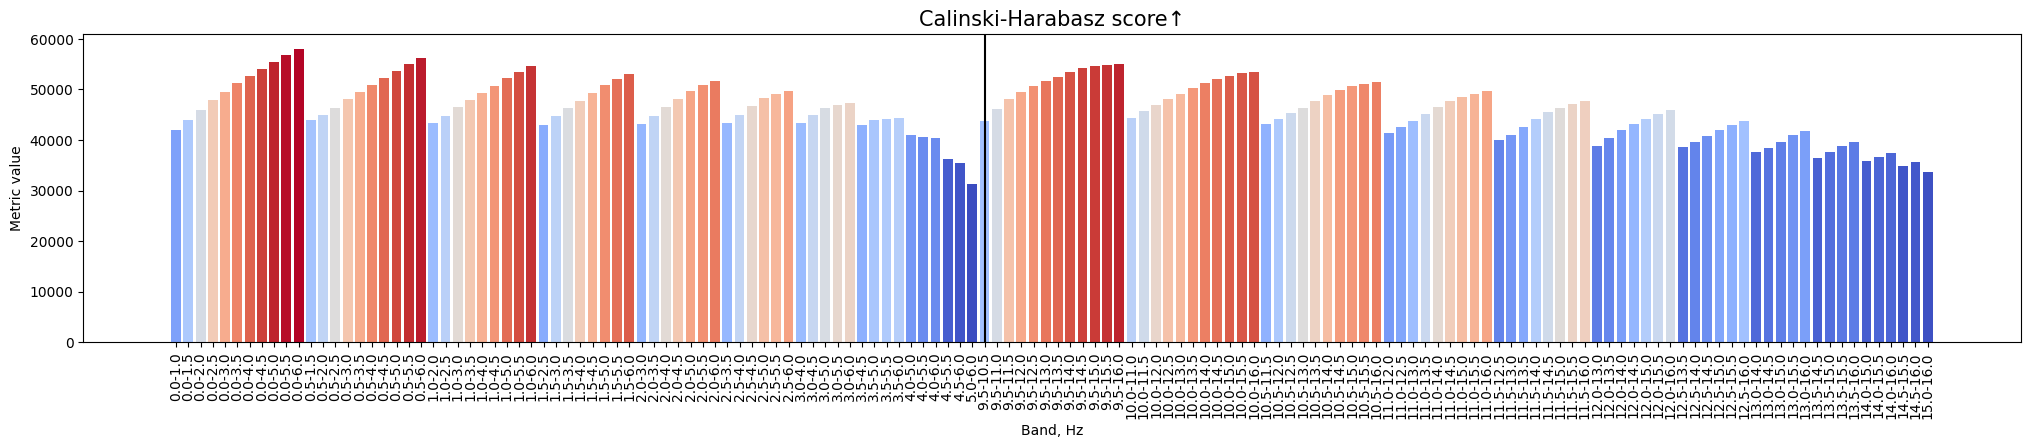

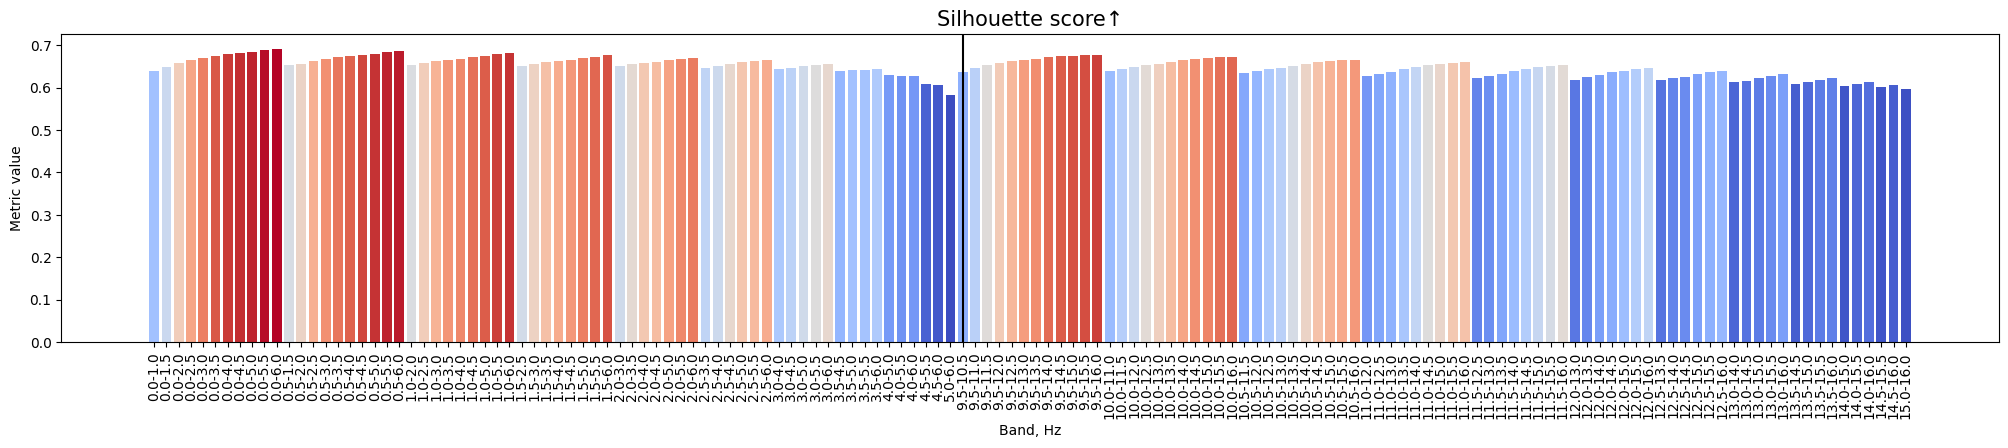

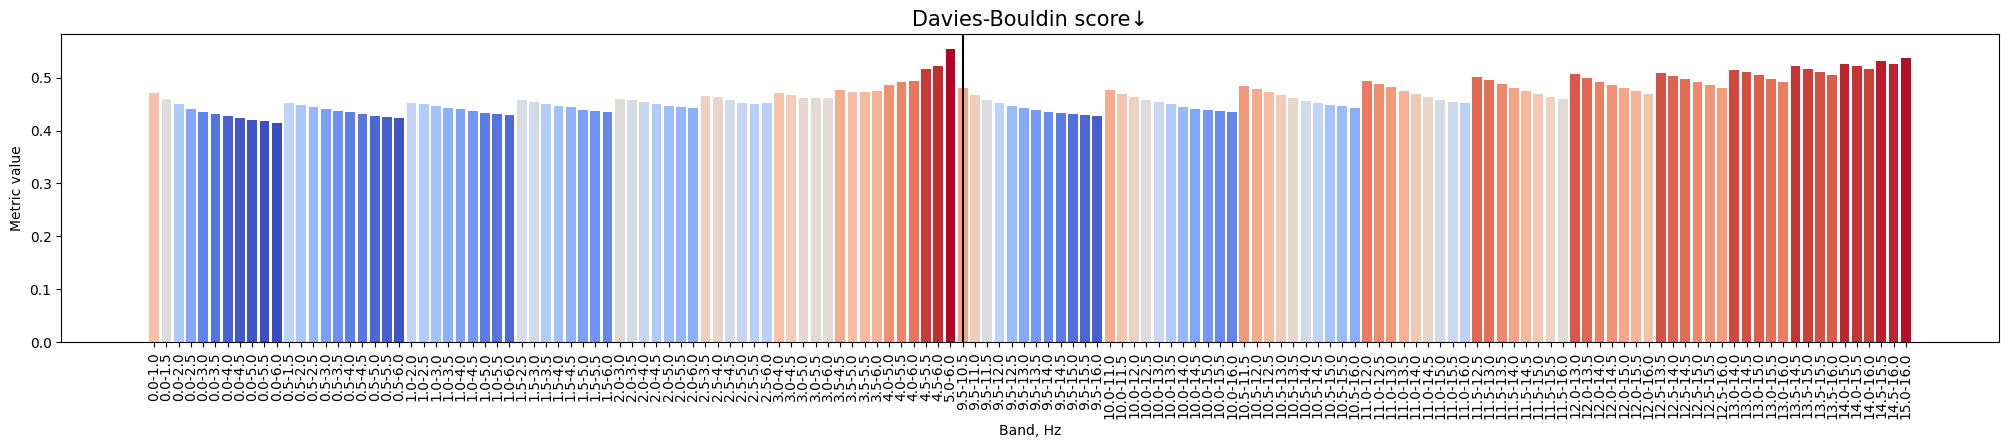

In [13]:
# metrics = cluster_metrics_d_s(series)
vis_d_s_metrics(metrics, dbands, sbands)

### generate sets of frequency bands for REM identification by providing rough theta frequency band you want to search within (mininmum band width is 1 Hz and step is 0.5 Hz by default)

In [15]:
theta_freqs = (5, 10)
tbands = gen_t_bands(theta_freqs)

### calculate series of FFT amplitudes for all the bands obtained using the hippocampal channel (or any other with pronounced theta activity)

In [42]:
tseries = extract_fft_amps(eeg[2], tbands)

### calculate series of theta/delta FFT amplitudes ratios using different theta bands and a single delta band (we suggest using the best one based on the clustering metrics above and the default smoothing windows at least when 5-second analysis window is used)

In [43]:
ratios = ratios_search(tseries, series[10], sm_w=5, dc_w=100)

### calculate and visualize a cluster metric (99th percentile - median) for each ratio

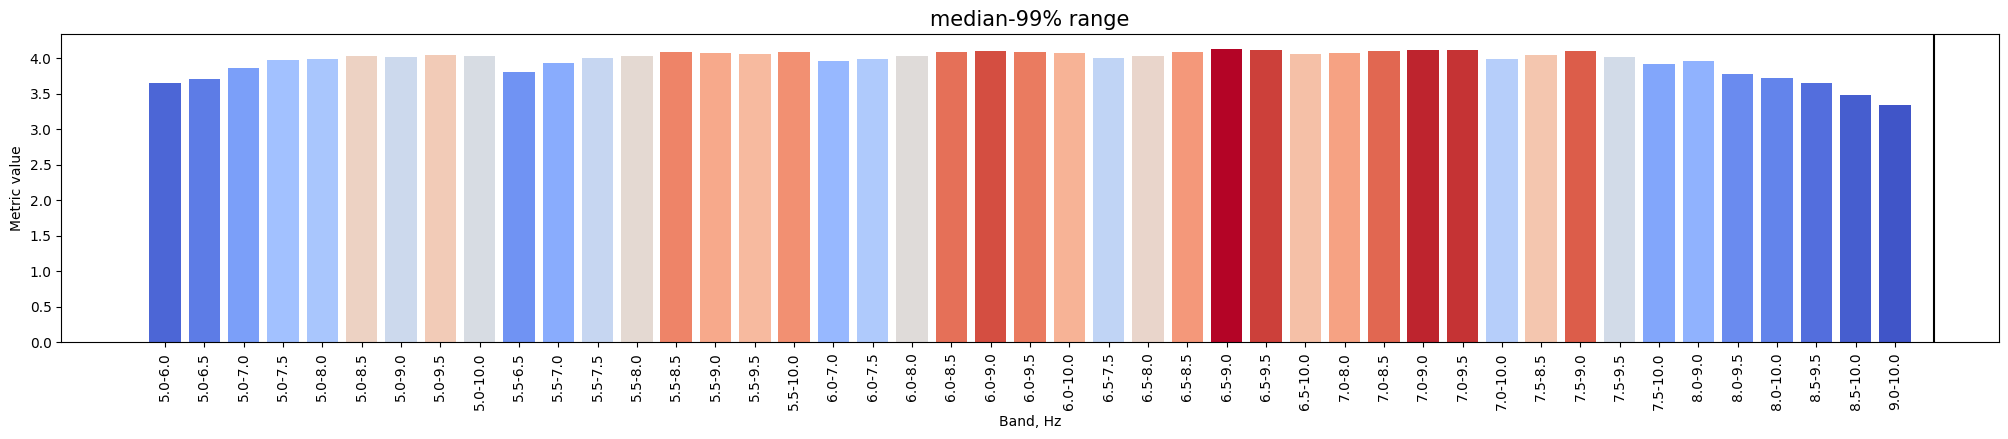

In [44]:
ratio_qual = ratio_metric(ratios)
vis_ratio_metric(ratio_qual, tbands)

# Vigilance state identification

### Identify artifacts by maximum amplitudes of cortical signal

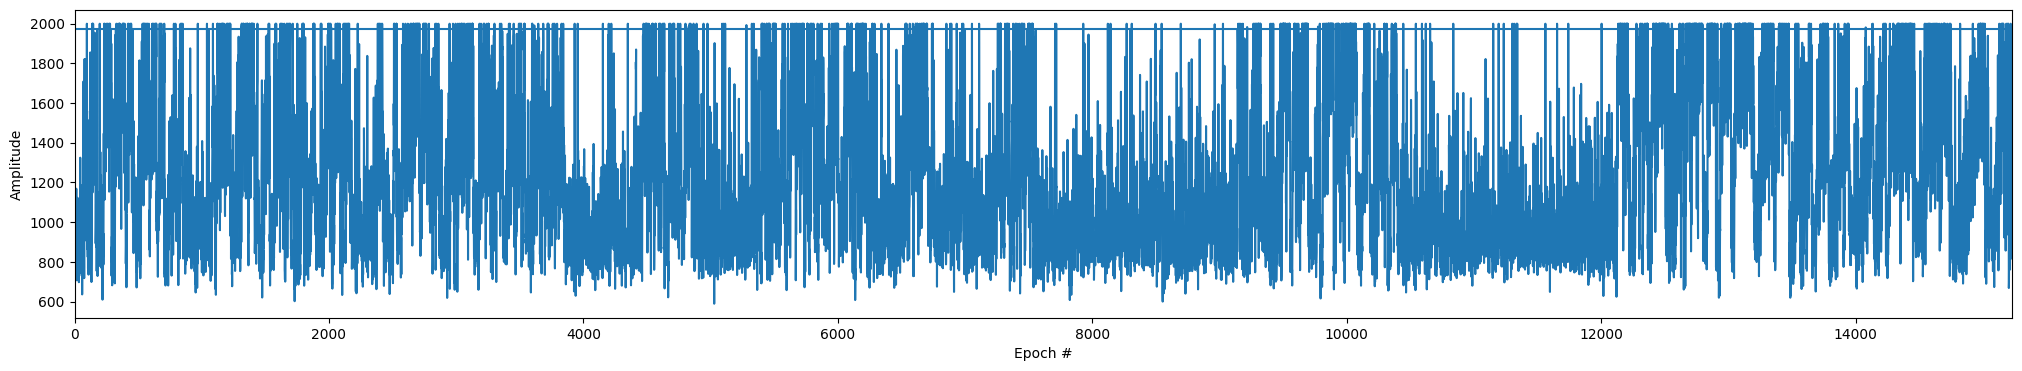

In [48]:
data = eeg[0]
window_sec = 5
sf =1000
epochs_cortex = np.vstack([data[i*window_sec*sf:(i+1)*window_sec*sf].reshape((1, -1)) for i in range(data.size//(window_sec*sf))])
artifact_thr, art_mask = art_thr(np.max(epochs_cortex, axis=1))

### calculate the smoothed delta by providing the cortical channel data, band of interest, analysis window length in sec, sampling frequency; we recommend using smoothing window for sliding mean sm_w=25 at least when window_sec=5 

In [109]:
dband = (0, 6)
window_sec, sf= 5, 1000
delta_raw, delta_sm = prepare_delta(data, dband, window_sec=window_sec, sf=sf, sm_w=15)

### identify NREM by providing the delta series, the number of part for which GMM models should be applied to independently (considering circadian cycle), and artifacts locations to exclude them from the analysis

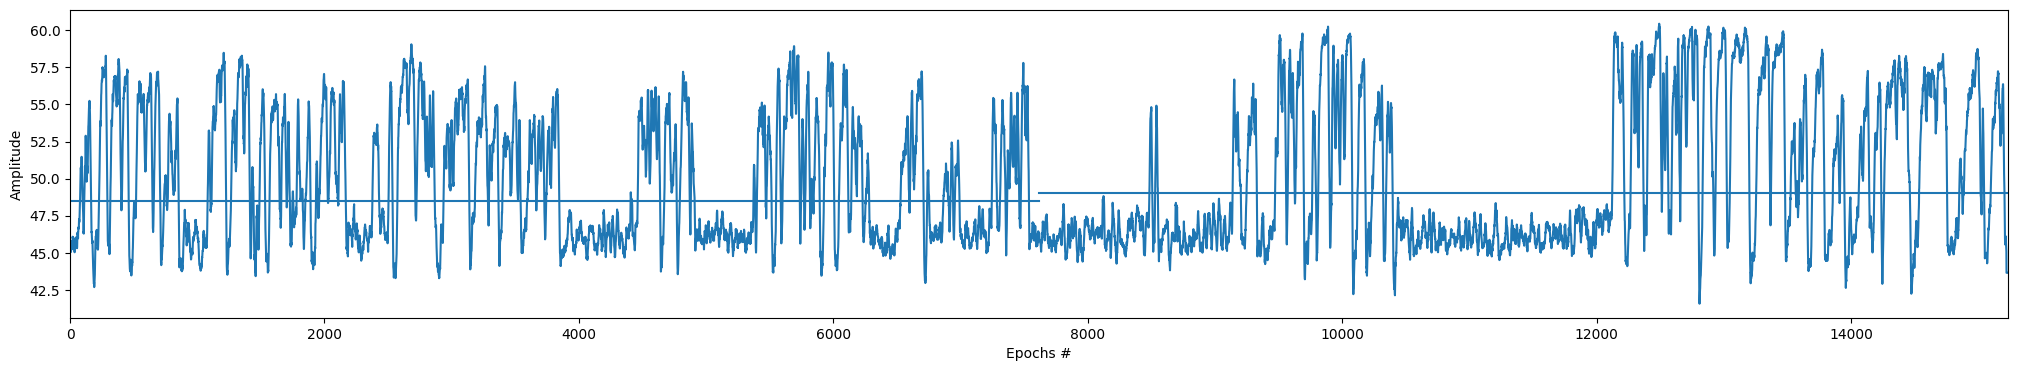

In [111]:
n_parts = 2
delta_thrs = scoring_utils.gm_delta_scoring(delta_sm, cycles=n_parts, mask=art_mask)
scoring_utils.vis_delta_res(delta_sm, delta_thrs)

### calculate the smoothed theta/delta ratio by providing the hippocampus channel data, band of interest, delta series for ration calculation, analysis window length in sec, sampling frequency; we recommend using smoothing window for sliding mean sm_w=5 and for DC-filtering dc_w=100 at least when window_sec=5

In [75]:
tband = (5.5, 9)
data = eeg[2]
ratio = prepare_ratio(data, tband, delta_raw, window_sec=window_sec, sf=sf, dc_w=100)

### identify REM by providing the ratio series and artifacts locations to exclude them from the analysis

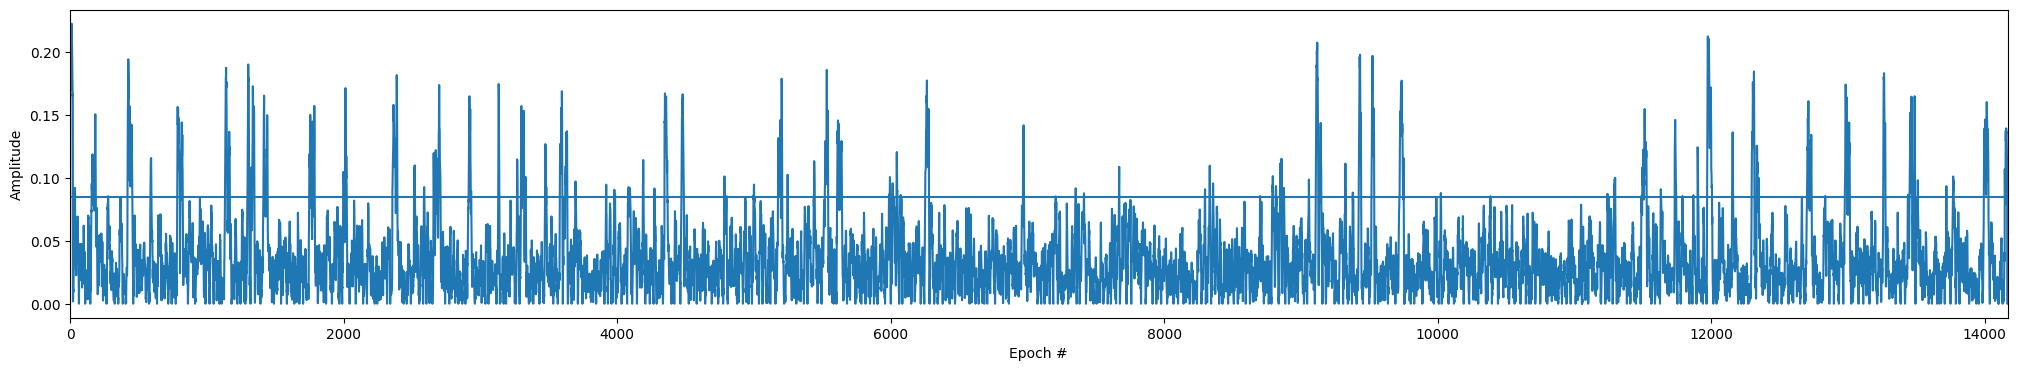

In [82]:
rem_thr, rem_mask = art_thr(ratio[art_mask])

### finally, combine NREM and REM identification results to obtain 3-state hypnogram by providing artifact identification results, smoothed delta and ratio series, thresholds for NREM and REM identifications (contextual rules are applied by default)

In [112]:
hypno = stage(art_mask, delta_sm, ratio, delta_thrs, rem_thr)

### if presented, load the expert hypnogram (we do it for our lab-specific hypnogram storage format) and calcualte sleep scoring confusion matrix and accuracy

In [113]:
expert_fname = r'D:\cumchatka\sleep\26.11.21 5 scoring.xlsx'
expert_scores = prepare_scores(expert_fname)
min_len = min(len(expert_scores), len(hypno))
m = cm(expert_scores[:min_len], hypno[:min_len])
print(m, acc(expert_scores[:min_len], hypno[:min_len]))

[[6166  301   32]
 [1106 6457   20]
 [ 526   94  526]] 0.8634751773049646
